# Sheet 8

In [2]:
import os
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

## 1) Anomaly detection for Autoencoders

### Preprocessing (delete later!)

In [5]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data06"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "toptagging-short.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
os.chdir("..")
%ls data06

100% [........................................................................] 68105824 / 68105824

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.33it/s]


 Volume in Laufwerk C: hat keine Bezeichnung.
 Volumeseriennummer: 4EEC-76C9

 Verzeichnis von C:\Users\mikah\OneDrive\jupyter_WS\MLP\Sheet8\data06\data06

05.01.2024  20:39    <DIR>          .
05.01.2024  20:39    <DIR>          ..
05.01.2024  20:39    <DIR>          toptagging-short
05.01.2024  20:39        68.105.824 toptagging-short.zip
               1 Datei(en),     68.105.824 Bytes
               3 Verzeichnis(se), 529.376.395.264 Bytes frei


In [3]:
# load data
X_train = np.load( "data06/toptagging-short/x_train_short.npy")
y_train = np.load( "data06/toptagging-short/y_train_short.npy")
X_test = np.load( "data06/toptagging-short/x_test_short.npy")
y_test = np.load( "data06/toptagging-short/y_test_short.npy")
X_val = np.load( "data06/toptagging-short/x_val_short.npy")
y_val = np.load( "data06/toptagging-short/y_val_short.npy")

print(f"train data shape: {X_train.shape}")
print(f"train labels shape: {y_train.shape}")
print(f"test data shape: {X_test.shape}")
print(f"test labels shape: {y_test.shape}")
print(f"val data shape: {X_val.shape}")
print(f"val labels shape: {y_val.shape}")

train data shape: (30000, 200, 4)
train labels shape: (30000,)
test data shape: (30000, 200, 4)
test labels shape: (30000,)
val data shape: (30000, 200, 4)
val labels shape: (30000,)


In [4]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)
    
    print( "Calculating eta" )
    etas  = eta(pT,pzs)
    
    print( "Calculating phi" )
    phis  = phi(pxs,pys)
    
    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)
    
    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)
    
    #return z_ori
        
    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum
    
    print( "Reshaping" )
    z_out = z_new.reshape( (z_new.shape[0],-1) ).reshape(-1, 1, 40,40)
    
    return z_out

In [5]:
z_train = constit_to_img( X_train, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping


[1. 1. 1. ... 1. 1. 1.]


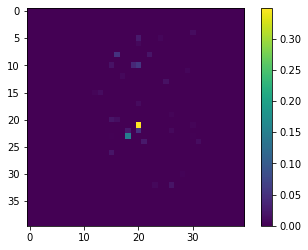

In [6]:
plt.imshow(z_test[5,0])
plt.colorbar()
print(np.sum(z_test[:,0],axis=(1,2)))

### Loading data from sheet 06

(a) 
Questions: Do I need ReLu's for the NN? --> Try

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [8]:
# TODO: Construct autoencoder
class autoencoder(nn.Module):
    
    def __init__(self, in_ch=1, ch=4, bottleneck_dim=50, img_sz=40):
        super().__init__()
        flatten = nn.Flatten()
        encode1 = nn.Linear(img_sz**2, 400, bias=True)
        encode2 = nn.Linear(400, 100, bias=True)
        encode3 = nn.Linear(100, bottleneck_dim, bias=True)
        decode1 = nn.Linear(bottleneck_dim, 100, bias=True)
        decode2 = nn.Linear(100, 400, bias=True)
        decode3 = nn.Linear(400, img_sz**2, bias=True)
        

        # define encoder and decoder in seperate methods
        self.encoder = nn.Sequential(
            flatten, # 1600
            encode1, # 400
            nn.ReLU(),
            encode2, # 100
            nn.ReLU(),
            encode3, # bottleneck dim
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            decode1, # bottleneck dim
            nn.ReLU(),
            decode2, # 400
            nn.ReLU(),
            decode3 # 1600
            #nn.Sigmoid() # get back pixel values between 0 and 1!
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return nn.functional.normalize(decoded)

    

(b)

In [9]:
# TODO: Train autoencoder on QCD jets
# Choose the bottleneck dimension between 5 and 20

In [10]:
# set up training data & dataloader for QCD jets only
class ae_data( torch.utils.data.Dataset ):
    
    def __init__( self, imgs, labels, qcd=True, top=False ):
        self.labels = labels

        # depending on input QCD, top or both are returned
        if qcd and not top:
            self.imgs = imgs[ labels == 0 ]
        elif top and not qcd:
            self.imgs = imgs[ labels == 1 ]
        elif qcd and top:
            self.imgs = imgs
        self.imgs = torch.Tensor(self.imgs).float()


    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, idx):
        return self.imgs[idx]

# load QCD only
train_dataset = ae_data(z_train, y_train, qcd=True, top=False)
test_dataset = ae_data(z_test, y_test, qcd=True, top=False)
val_dataset = ae_data(z_val, y_val, qcd=True, top=False)

trn_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True )
tst_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False )
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False )

In [11]:
def batch_loss(model, loss_fn, x):
    x = x.to(device)
    x_flat = x.reshape(-1, 40*40)
    pred = model(x)
    loss = loss_fn(pred, x_flat)
    return loss

In [12]:
def train_epoch(model, dataloader, loss_fn, losses, batch_loss_fn):
    for x in dataloader:
        optimizer.zero_grad()
        
        loss = batch_loss_fn(model, loss_fn, x)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [13]:
def val_epoch(model, dataloader, loss_fn, losses, batch_loss_fn):
    losses_epoch = []
    with torch.no_grad():
        for x in dataloader:
            loss = batch_loss_fn(model, loss_fn, x)
            losses_epoch.append(loss.item())
    losses.append(np.mean(losses_epoch))
    return losses

In [14]:
n_epochs = 10
bottleneck_dim = 15
loss_fn = nn.MSELoss()

model = autoencoder(bottleneck_dim=bottleneck_dim).to(device)
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    train_losses = train_epoch(model, trn_dataloader, loss_fn, train_losses, batch_loss)
    
    val_losses = val_epoch(model, val_dataloader, loss_fn, val_losses, batch_loss)
    
    if epoch%1==0:
        print(f"{epoch + 1} / {n_epochs}")

autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1600, out_features=400, bias=True)
    (2): ReLU()
    (3): Linear(in_features=400, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=15, bias=True)
    (6): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=400, bias=True)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=1600, bias=True)
  )
)
Model has 1365615 trainable parameters
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


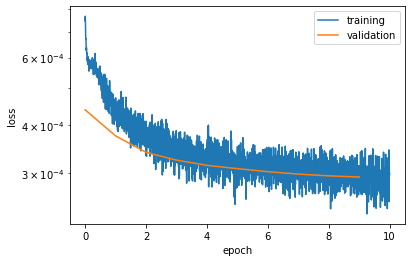

In [15]:
# plot train and validation loss
plt.plot(np.arange(len(train_losses)) / len(trn_dataloader), train_losses, label='training')
plt.plot(np.arange(len(val_losses)), val_losses, label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()

This figure shows a fast trainin within the first few epochs, followed by a stabilization. Train loss???

(c)

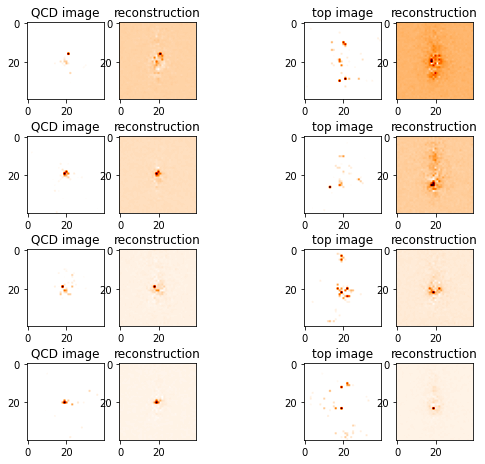

In [16]:
# TODO: Visualize original vs reconstructed QCD and top jets

#load training data for qcd and top jets seperately
train_dataset_qcd = ae_data(z_train, y_train, qcd=True, top=False)
train_dataset_top = ae_data(z_train, y_train, qcd=False, top=True)
train_dataloader_qcd = torch.utils.data.DataLoader(train_dataset_qcd, batch_size=64, shuffle=True)
train_dataloader_top = torch.utils.data.DataLoader(train_dataset_top, batch_size=64, shuffle=True)

plt.figure(figsize=(8,8))
for i in range(4):
    ### QCD jets ###
    # get image and its reconstruction
    img = train_dataloader_qcd.dataset[i].to(device)
    out = model(img).reshape(40,40).detach().cpu().numpy()
    # plot original image
    plt.subplot(4,5,5*i+1)
    img_cpu = img.reshape(40,40).detach().cpu().numpy()
    plt.imshow(img_cpu, cmap='gist_heat_r')
    plt.title('QCD image')
    # plot reconstructed image
    plt.subplot(4,5,5*i+2)
    plt.imshow(out, cmap='gist_heat_r')
    plt.title('reconstruction')

    ### top jets ###
    # get image and its reconstruction
    img = train_dataloader_top.dataset[i].to(device)
    out = model(img).reshape(40,40).detach().cpu().numpy()
    # plot original image
    plt.subplot(4,5,5*i+4)
    img_cpu = img.reshape(40,40).detach().cpu().numpy()
    plt.imshow(img_cpu, cmap='gist_heat_r')
    plt.title('top image')
    # plot reconstructed image
    plt.subplot(4,5,5*i+5)
    plt.imshow(out, cmap='gist_heat_r')
    plt.title('reconstruction')

In [17]:
img_qcd = []
out_qcd = []
img_top = []
out_top = []

for i in range(1000):
    # get image and its reconstruction for entire batch
    img = train_dataloader_qcd.dataset[i].to(device)
    out = model(img).reshape(40,40).detach().cpu().numpy()
    img_qcd.append(img.cpu().numpy()[0])
    out_qcd.append(out)

    img = train_dataloader_top.dataset[i].to(device)
    out = model(img).reshape(40,40).detach().cpu().numpy()
    img_top.append(img.cpu().numpy()[0])
    out_top.append(out)

It seems that the network has learned to reconstruct images with a peak at their center and a vertical spread. Therefore, for the top images, the autoencoder fails to reconstruct the three lumps and instead tries to fit a single peak.

(d)

total MSE QCD: 0.083
total MSE top: 0.222


Text(0.5, 1.0, 'Pixelwise MSE top')

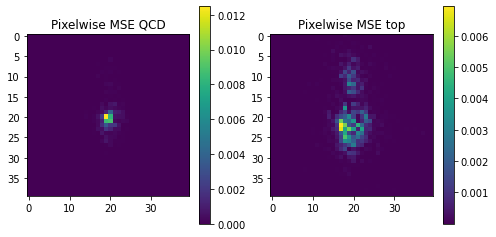

In [18]:
# TODO: Visualize pixel-wise MSE, plot ROC
# pixel wide MSE, scaled by average pixel value
MSE_qcd = (np.mean(np.array(img_qcd),axis=0) - np.mean(np.array(out_qcd), axis=0))**2 
MSE_top = (np.mean(np.array(img_top),axis=0) - np.mean(np.array(out_top), axis=0))**2
# MSE_top = np.mean((np.array(img_top) - np.array(out_top))**2, axis=0) / AVG_top

print('total MSE QCD:', round(MSE_qcd.sum(),3))
print('total MSE top:', round(MSE_top.sum(),3))

fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(MSE_qcd)
plt.colorbar()
plt.title('Pixelwise MSE QCD')
plt.subplot(1,2,2)
plt.imshow(MSE_top)
plt.colorbar()
plt.title('Pixelwise MSE top')

Note that we first took the mean across input images and reconstructions seperately, before calculating the pixelwide squared error. This is because although the autoencoder can reproduce the general shape of the signal, it cannot reproduce the exact axtive pixels. The error is much smaller and spacially centered for the QCD jets than the top jets.

In [19]:
# ROC curve


In [20]:
score_im = model(torch.from_numpy(z_test.astype(np.float32)))
score_im = score_im.detach().numpy()

In [21]:
print(score_im.shape)
print(z_test.reshape(score_im.shape).shape)
score = np.sum((z_test.reshape(score_im.shape)-score_im)**2 , axis=1)
print(score.shape)

(30000, 1600)
(30000, 1600)
(30000,)


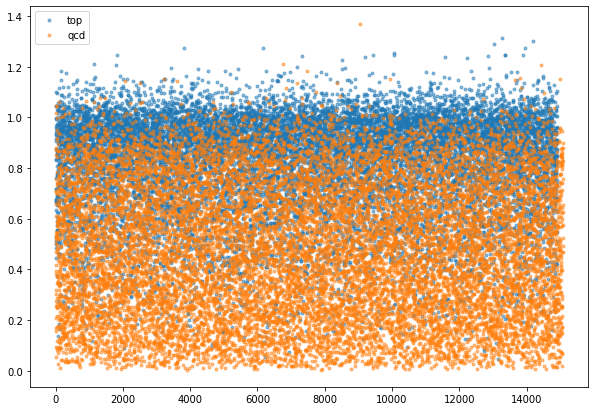

In [22]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(len(score[y_test==1])),score[y_test==1],label="top",linestyle="None",marker=".",alpha=0.5)
plt.plot(np.arange(len(score[y_test==0])),score[y_test==0],label="qcd",linestyle="None",marker=".",alpha=0.5)
plt.legend()
plt.show()

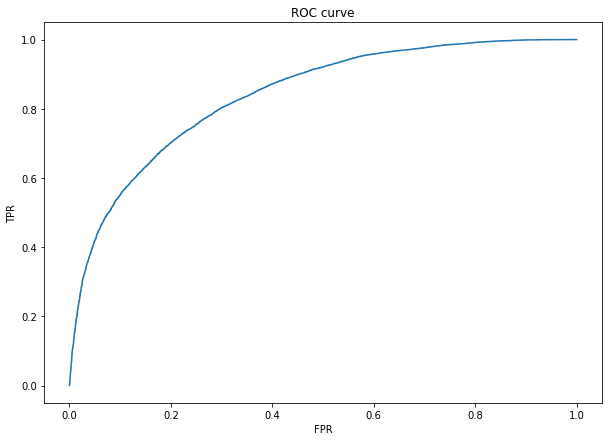

<ipython-input-23-dd198f55aafc>:19: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


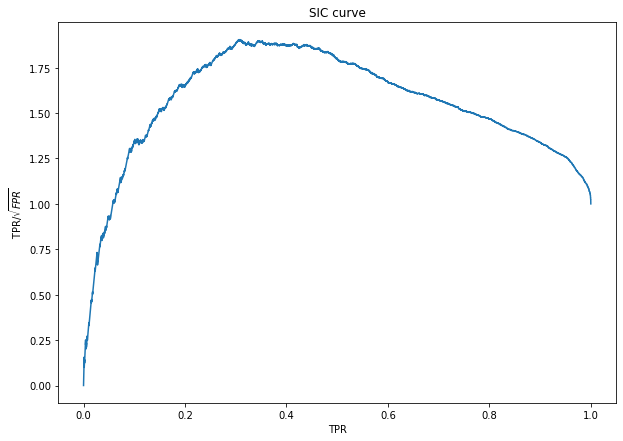

AUC score: 0.8389357652839903


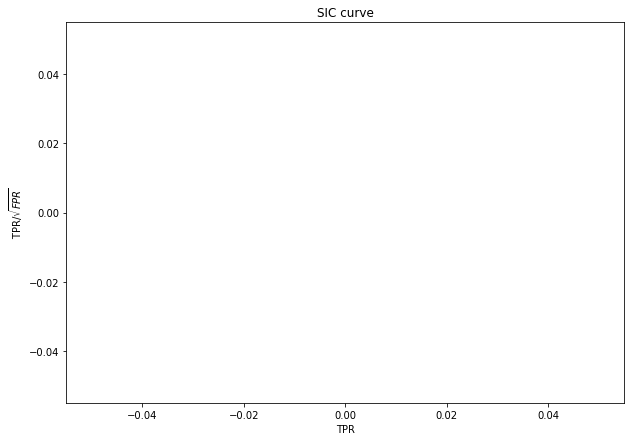

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score
# TODO: Compute tpr, fpr, auc_score

fpr,tpr,threshholds = roc_curve(y_test,score)
auc = roc_auc_score(y_test,score)


# TODO: Plot ROC and SIC curve

plt.figure(figsize=(10,7))
plt.title("ROC curve")
plt.plot(fpr,tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

plt.figure(figsize=(10,7))
plt.title("SIC curve")
plt.plot(tpr,tpr/np.sqrt(fpr))
plt.xlabel("TPR")
plt.ylabel("TPR/$\\sqrt{FPR}$")
plt.show()

print("AUC score: "+str(auc))

plt.figure(figsize=(10,7))
plt.title("SIC curve")
plt.plot(np.arange(len(threshholds[10000:])),threshholds[10000:])
plt.xlabel("TPR")
plt.ylabel("TPR/$\\sqrt{FPR}$")
plt.show()

In [24]:
# TODO: Implement and train CNN
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.networksequ = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=(3,3), stride=(1,1), padding=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Conv2d(5, 10, kernel_size=(3,3), stride=(1,1), padding=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )
        self.linear = nn.Linear(10*10*10,1)

    def forward(self, x):
        x = self.networksequ(x)
        x = flatten(x,start_dim=1)
        x = self.linear(x)
        x = flatten(x)
        x = F.sigmoid(x)
        return x

In [25]:
# TODO: Implement and train CNN
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super().__init__()
        self.networksequ = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=(3,3), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Conv2d(10, 4, kernel_size=(3,3), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2)
        )
        self.linear = nn.Linear(4*10*10,50)
        self.linear2= nn.Linear(50,1)

    def forward(self, x):
        x = self.networksequ(x)
        x = flatten(x,start_dim=1)
        x = self.linear(x)
        x = nn.ReLU()(x)
        x = self.linear2(x)
        x = flatten(x)
        x = F.sigmoid(x)
        return x

In [26]:
net = NeuralNetwork2()

In [30]:
# define new data
z_train_new = (((model(torch.from_numpy(z_train.astype(np.float32)))).detach().numpy()).reshape(z_train.shape)-z_train)**2
z_val_new = (((model(torch.from_numpy(z_val.astype(np.float32)))).detach().numpy()).reshape(z_val.shape)-z_val)**2
z_test_new = (((model(torch.from_numpy(z_test.astype(np.float32)))).detach().numpy()).reshape(z_test.shape)-z_test)**2



In [47]:
iterations=1000
epoches=2
batchlettsize=1000
trainsize = 30000

import torch.optim as optim
from torch import flatten

rng = np.random.default_rng()

lossfn = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [40]:
lossarray=np.empty((0))

In [41]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [42]:
from torch.nn import functional as F

In [48]:
for epoch in range(epoches):
    
    running_loss=0
    for i in range(iterations):
        
        args=rng.choice(trainsize, size=batchlettsize, replace=False)
        dataset=torch.from_numpy(z_train_new[args].astype(np.float32))
        labelset=torch.from_numpy(y_train[args].astype(np.float32))
        
        
        optimizer.zero_grad()
        
        output = net(dataset)
        loss = lossfn(output, labelset)
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item()
        lossarray=np.append(lossarray,loss.item())
        print(str(round(i*100/iterations,1))+"%",end="\r")
        if i % 100 == 99:
            print(str(i+1)+": loss per 100 = "+str(running_loss/100))
            running_loss=0

100: loss per 100 = 0.368157442510128
200: loss per 100 = 0.3607312107086182
300: loss per 100 = 0.3639323738217354
400: loss per 100 = 0.3590514215826988
500: loss per 100 = 0.3585744062066078
600: loss per 100 = 0.35762712568044663
700: loss per 100 = 0.3577570486068726
800: loss per 100 = 0.3553512689471245
900: loss per 100 = 0.35982455015182496
1000: loss per 100 = 0.3550513881444931
100: loss per 100 = 0.35334538787603376
200: loss per 100 = 0.3499851620197296
300: loss per 100 = 0.3550483384728432
400: loss per 100 = 0.3494047927856445
500: loss per 100 = 0.34823008865118027
600: loss per 100 = 0.3494703847169876
700: loss per 100 = 0.3475173309445381
800: loss per 100 = 0.3487482735514641
900: loss per 100 = 0.3460490965843201
1000: loss per 100 = 0.3462788635492325


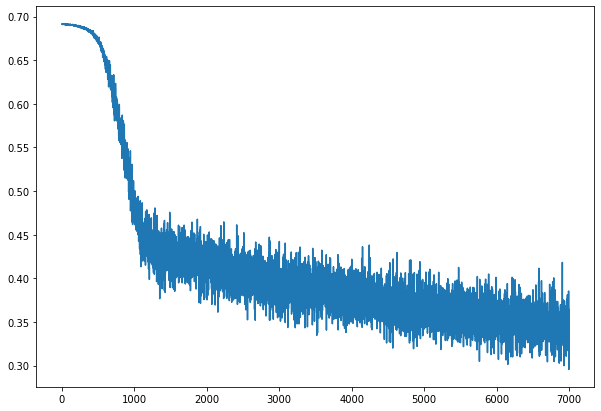

In [49]:
# TODO: Plot loss
x_plot=np.arange(len(lossarray))
plt.figure(figsize=(10,7))
plt.plot(x_plot,lossarray)
plt.show()

In [50]:
score = net(torch.from_numpy(z_test_new.astype(np.float32)))
score = score.detach().numpy()

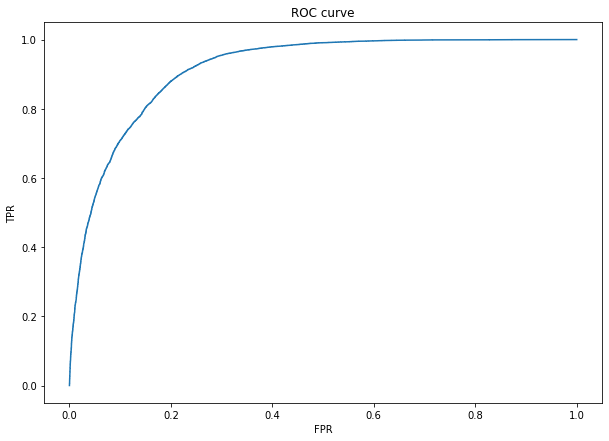

<ipython-input-51-ed7b1e220267>:19: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
<ipython-input-51-ed7b1e220267>:19: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


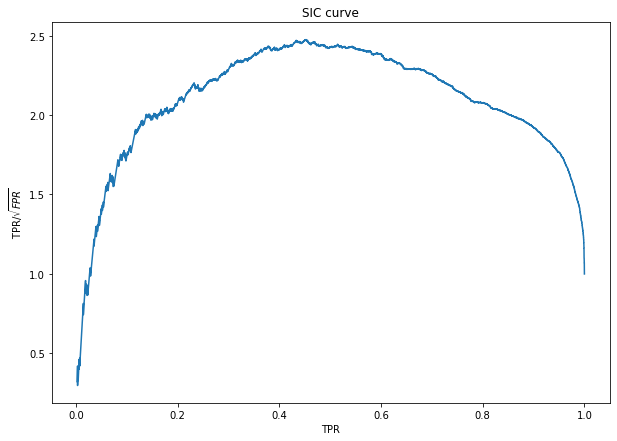

AUC score: 0.9158195344223125


In [51]:
from sklearn.metrics import roc_curve, roc_auc_score
# TODO: Compute tpr, fpr, auc_score

fpr,tpr,threshholds = roc_curve(y_test,score)
auc = roc_auc_score(y_test,score)


# TODO: Plot ROC and SIC curve

plt.figure(figsize=(10,7))
plt.title("ROC curve")
plt.plot(fpr,tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

plt.figure(figsize=(10,7))
plt.title("SIC curve")
plt.plot(tpr,tpr/np.sqrt(fpr))
plt.xlabel("TPR")
plt.ylabel("TPR/$\\sqrt{FPR}$")
plt.show()

print("AUC score: "+str(auc))

In [52]:
torch.save(net,"NeuralNetwork1")

In [ ]:
#Load model with

#net = torch.load("NeuralNetwork1")

#net.eval()

(e)

In [142]:
# TODO: Repeat everything for CNN
class CNN_autoencoder(nn.Module):
    
    def __init__(self, in_ch=1, bottleneck_dim=10, img_sz=40):
        super().__init__()
        conv1 = nn.Conv2d(in_ch, 4, kernel_size=5,  bias=True, stride=1, padding=2)
        conv2 = nn.Conv2d(4, 1, kernel_size=5,  bias=True, stride=1, padding=2)
        maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        flatten = nn.Flatten()
        encode0 = nn.Linear(5*20*20, 400, bias=True)
        encode1 = nn.Linear(400, 100, bias=True)
        encode2 = nn.Linear(100, bottleneck_dim, bias=True)
        unflatten = nn.Unflatten(1, (1,20,20))
        upsample = nn.Upsample(scale_factor=2, mode='nearest') # "inverse" of avgpool
        deconv0 = nn.ConvTranspose2d(1, 5, kernel_size=5, bias=True, stride=1, padding=2)
        deconv1 = nn.ConvTranspose2d(1, 4, kernel_size=5, bias=True, stride=2, padding=2, output_padding=1)
        deconv2 = nn.ConvTranspose2d(4, in_ch, kernel_size=5, bias=True, stride=1, padding=2)
        
        decode1 = nn.Linear(bottleneck_dim, 100, bias=True)
        decode2 = nn.Linear(100, 400, bias=True)

        # define encoder and decoder in seperate methods
        self.encoder = nn.Sequential(
            conv1,
            nn.ReLU(),
            conv2,
            nn.ReLU(),
            maxpool,
        )
        
        self.bottleneck = nn.Sequential(
            flatten,
            encode1,
            nn.ReLU(),
            encode2,
            nn.ReLU(),
            decode1,
            nn.ReLU(),
            decode2,
            nn.ReLU(),
            unflatten
        )
    
        self.decoder = nn.Sequential(
            deconv1,
            nn.ReLU(),
            deconv2,
            nn.Sigmoid() # get back pixel values between 0 and 1
        )



    def forward(self, x):
        encoded = self.encoder(x)
        bottle = self.bottleneck(encoded)
        decoded = self.decoder(bottle)
        return decoded

In [212]:
# TODO: Repeat everything for CNN
class CNN_autoencoder(nn.Module):
    
    def __init__(self, in_ch=1, bottleneck_dim=50, img_sz=40):
        super().__init__()
        conv1 = nn.Conv2d(in_ch, 4, kernel_size=5,  bias=True, stride=1, padding=2)
        conv2 = nn.Conv2d(4, 1, kernel_size=5,  bias=True, stride=1, padding=2)
        maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        flatten = nn.Flatten()
        encode0 = nn.Linear(5*20*20, 400, bias=True)
        encode1 = nn.Linear(400, 100, bias=True)
        encode2 = nn.Linear(100, bottleneck_dim, bias=True)
        unflatten = nn.Unflatten(1, (1,20,20))
        upsample = nn.Upsample(scale_factor=2, mode='nearest') # "inverse" of avgpool
        deconv0 = nn.ConvTranspose2d(1, 5, kernel_size=5, bias=True, stride=1, padding=2)
        deconv1 = nn.ConvTranspose2d(1, 4, kernel_size=5, bias=True, stride=2, padding=2, output_padding=1)
        deconv2 = nn.ConvTranspose2d(4, in_ch, kernel_size=5, bias=True, stride=1, padding=2)
        
        decode1 = nn.Linear(bottleneck_dim, 100, bias=True)
        decode2 = nn.Linear(100, 400, bias=True)

        # define encoder and decoder in seperate methods
        self.encoder = nn.Sequential(
            conv1,
            nn.ReLU(),
            maxpool,
            conv2,
            nn.ReLU()
        )
        
        self.bottleneck = nn.Sequential(
            flatten,
            encode1,
            nn.ReLU(),
            encode2,
            nn.ReLU(),
            decode1,
            nn.ReLU(),
            decode2,
            nn.ReLU(),
            unflatten
        )
    
        self.decoder = nn.Sequential(
            deconv1,
            nn.ReLU(),
            deconv2,
            nn.Sigmoid() # get back pixel values between 0 and 1
        )



    def forward(self, x):
        encoded = self.encoder(x)
        bottle = self.bottleneck(encoded)
        decoded = self.decoder(bottle)
        return decoded

In [225]:
def batch_loss(model, loss_fn, x):
    x = x.to(device)
    x_flat = x.reshape(-1, 40*40)
    pred = model(x)
    pred_flat = pred.reshape(-1, 40*40)
    loss = loss_fn(pred_flat, x_flat)
    return loss

In [226]:
n_epochs = 2
bottleneck_dim = 12
loss_fn = nn.MSELoss()
del model
model = CNN_autoencoder(bottleneck_dim=bottleneck_dim).to(device)
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    train_losses = train_epoch(model, trn_dataloader, loss_fn, train_losses, batch_loss)
    
    val_losses = val_epoch(model, val_dataloader, loss_fn, val_losses, batch_loss)
    
    if epoch%1==0:
        print(f"{epoch + 1} / {n_epochs}")

CNN_autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
  )
  (bottleneck): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=12, bias=True)
    (4): ReLU()
    (5): Linear(in_features=12, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=400, bias=True)
    (8): ReLU()
    (9): Unflatten(dim=1, unflattened_size=(1, 20, 20))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(1, 4, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(4, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): Sigmoid()
  )
)

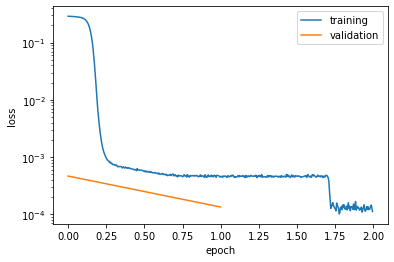

In [227]:
# plot train and validation loss
plt.plot(np.arange(len(train_losses)) / len(trn_dataloader), train_losses, label='training')
plt.plot(np.arange(len(val_losses)), val_losses, label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()

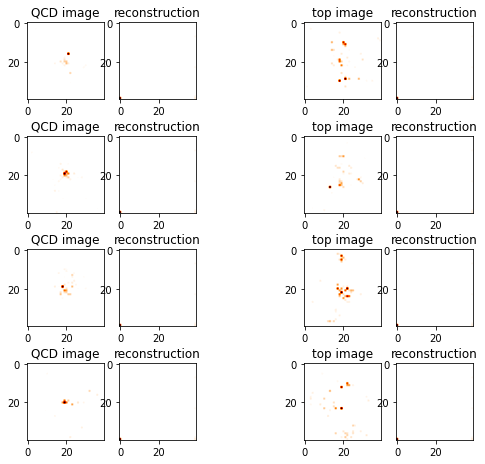

In [229]:
# TODO: Visualize original vs reconstructed QCD and top jets

#load training data for qcd and top jets seperately
train_dataset_qcd = ae_data(z_train, y_train, qcd=True, top=False)
train_dataset_top = ae_data(z_train, y_train, qcd=False, top=True)
train_dataloader_qcd = torch.utils.data.DataLoader(train_dataset_qcd, batch_size=64, shuffle=True)
train_dataloader_top = torch.utils.data.DataLoader(train_dataset_top, batch_size=64, shuffle=True)

plt.figure(figsize=(8,8))
for i in range(4):
    ### QCD jets ###
    # get image and its reconstruction
    img = train_dataloader_qcd.dataset[i].to(device)
    out = model(img).reshape(40,40).detach().cpu().numpy()
    # plot original image
    plt.subplot(4,5,5*i+1)
    img_cpu = img.reshape(40,40).detach().cpu().numpy()
    plt.imshow(img_cpu, cmap='gist_heat_r')
    plt.title('QCD image')
    # plot reconstructed image
    plt.subplot(4,5,5*i+2)
    plt.imshow(out, cmap='gist_heat_r')
    plt.title('reconstruction')

    ### top jets ###
    # get image and its reconstruction
    img = train_dataloader_top.dataset[i].to(device)
    out = model(img).reshape(40,40).detach().cpu().numpy()
    # plot original image
    plt.subplot(4,5,5*i+4)
    img_cpu = img.reshape(40,40).detach().cpu().numpy()
    plt.imshow(img_cpu, cmap='gist_heat_r')
    plt.title('top image')
    # plot reconstructed image
    plt.subplot(4,5,5*i+5)
    plt.imshow(out, cmap='gist_heat_r')
    plt.title('reconstruction')

In [230]:
img_qcd = []
out_qcd = []
img_top = []
out_top = []

for i in range(1000):
    # get image and its reconstruction for entire batch
    img = train_dataloader_qcd.dataset[i].to(device)
    out = model(img).reshape(40,40).detach().cpu().numpy()
    img_qcd.append(img.cpu().numpy()[0])
    out_qcd.append(out)

    img = train_dataloader_top.dataset[i].to(device)
    out = model(img).reshape(40,40).detach().cpu().numpy()
    img_top.append(img.cpu().numpy()[0])
    out_top.append(out)

total MSE QCD: 0.004
total MSE top: 0.293


Text(0.5, 1.0, 'Pixelwise MSE top')

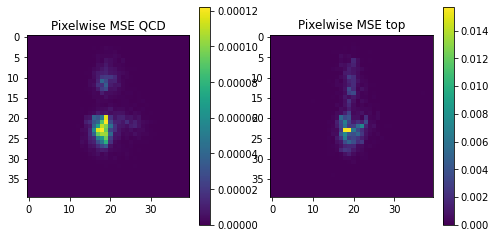

In [231]:
# TODO: Visualize pixel-wise MSE, plot ROC
# pixel wide MSE, scaled by average pixel value
MSE_qcd = (np.mean(np.array(img_qcd),axis=0) - np.mean(np.array(out_qcd), axis=0))**2 
MSE_qcd = (np.mean(np.array(img_top),axis=0) - np.mean(np.array(out_top), axis=0))**2
# MSE_top = np.mean((np.array(img_top) - np.array(out_top))**2, axis=0) / AVG_top

print('total MSE QCD:', round(MSE_qcd.sum(),3))
print('total MSE top:', round(MSE_top.sum(),3))

fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(MSE_qcd)
plt.colorbar()
plt.title('Pixelwise MSE QCD')
plt.subplot(1,2,2)
plt.imshow(MSE_top)
plt.colorbar()
plt.title('Pixelwise MSE top')

In [232]:
score_im = model(torch.from_numpy(z_test.astype(np.float32)))
score_im = (score_im.detach().numpy())[:,0]

In [233]:
score_im.shape

(30000, 40, 40)

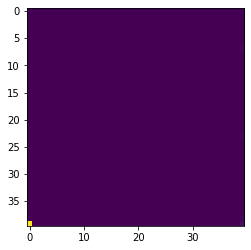

In [234]:
plt.imshow(score_im[500])

In [235]:
print(score_im.shape)
print(z_test.reshape(score_im.shape).shape)
score = np.sum((z_test.reshape(score_im.shape)-score_im)**2 , axis=(1,2))
print(score.shape)

(30000, 40, 40)
(30000, 40, 40)
(30000,)


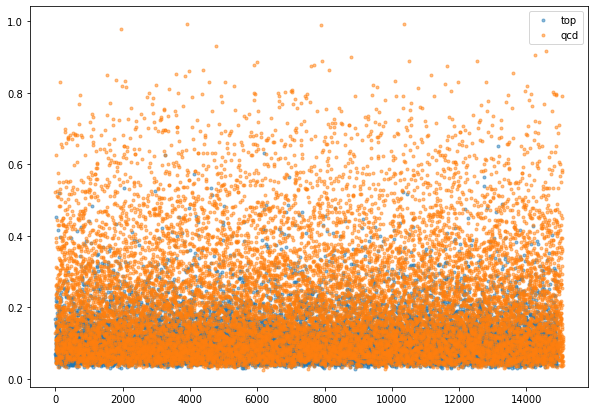

In [236]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(len(score[y_test==1])),score[y_test==1],label="top",linestyle="None",marker=".",alpha=0.5)
plt.plot(np.arange(len(score[y_test==0])),score[y_test==0],label="qcd",linestyle="None",marker=".",alpha=0.5)
plt.legend()
plt.show()

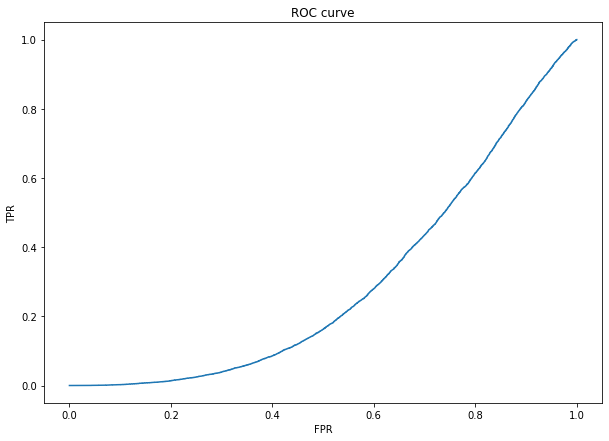

<ipython-input-224-dd198f55aafc>:19: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


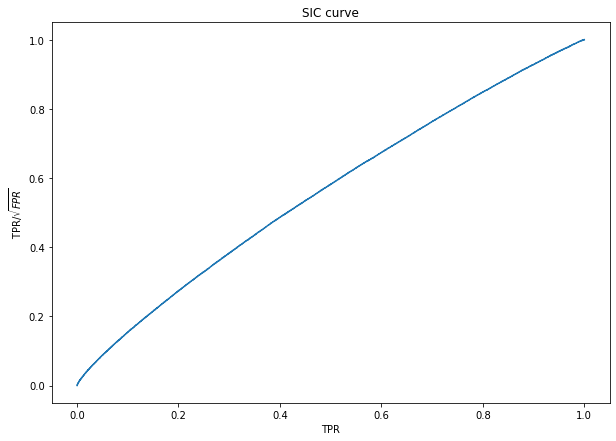

AUC score: 0.2946695417114087


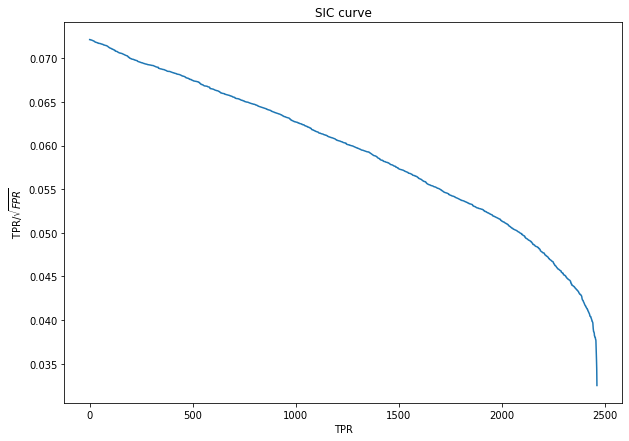

In [224]:
from sklearn.metrics import roc_curve, roc_auc_score
# TODO: Compute tpr, fpr, auc_score

fpr,tpr,threshholds = roc_curve(y_test,score)
auc = roc_auc_score(y_test,score)


# TODO: Plot ROC and SIC curve

plt.figure(figsize=(10,7))
plt.title("ROC curve")
plt.plot(fpr,tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

plt.figure(figsize=(10,7))
plt.title("SIC curve")
plt.plot(tpr,tpr/np.sqrt(fpr))
plt.xlabel("TPR")
plt.ylabel("TPR/$\\sqrt{FPR}$")
plt.show()

print("AUC score: "+str(auc))

plt.figure(figsize=(10,7))
plt.title("SIC curve")
plt.plot(np.arange(len(threshholds[10000:])),threshholds[10000:])
plt.xlabel("TPR")
plt.ylabel("TPR/$\\sqrt{FPR}$")
plt.show()

(f)

In [334]:
# TODO: Repeat everything for autoencoder trained on top jets
# You can either use a MLP or a CNN
train_dataset = ae_data(z_train, y_train, qcd=False, top=True)
test_dataset = ae_data(z_test, y_test, qcd=False, top=True)
val_dataset = ae_data(z_val, y_val, qcd=False, top=True)

trn_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True )
tst_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False )
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False )

In [344]:
n_epochs = 4
bottleneck_dim = 16
loss_fn = nn.MSELoss()

model = CNN_autoencoder(bottleneck_dim=bottleneck_dim).to(device)
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    train_losses = train_epoch(model, trn_dataloader, loss_fn, train_losses, batch_loss)
    
    val_losses = val_epoch(model, val_dataloader, loss_fn, val_losses, batch_loss)
    
    if epoch%1==0:
        print(f"{epoch+1} / {n_epochs}")

CNN_autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bottleneck): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=400, bias=True)
    (8): ReLU()
    (9): Unflatten(dim=1, unflattened_size=(1, 20, 20))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(1, 4, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(4, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): Sigmoid()
  )
)

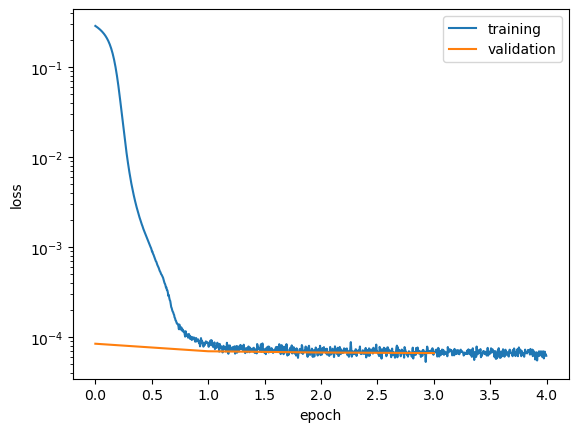

In [345]:
# plot train and validation loss
plt.plot(np.arange(len(train_losses)) / len(trn_dataloader), train_losses, label='training')
plt.plot(np.arange(len(val_losses)), val_losses, label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()

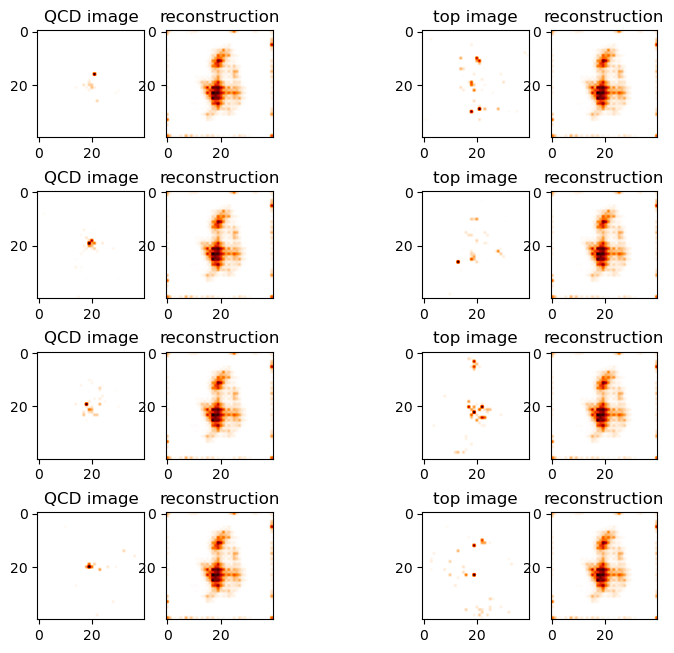

In [346]:
# Visualize original vs reconstructed QCD and top jets

#load training data for qcd and top jets seperately
train_dataset_qcd = ae_data(z_train, y_train, qcd=True, top=False)
train_dataset_top = ae_data(z_train, y_train, qcd=False, top=True)
train_dataloader_qcd = torch.utils.data.DataLoader(train_dataset_qcd, batch_size=64, shuffle=True)
train_dataloader_top = torch.utils.data.DataLoader(train_dataset_top, batch_size=64, shuffle=True)

plt.figure(figsize=(8,8))
for i in range(4):
    ### QCD jets ###
    # get image and its reconstruction
    img = train_dataloader_qcd.dataset[i].to(device)
    out = model(img).reshape(40,40).detach().cpu().numpy()
    # plot original image
    plt.subplot(4,5,5*i+1)
    img_cpu = img.reshape(40,40).detach().cpu().numpy()
    plt.imshow(img_cpu, cmap='gist_heat_r')
    plt.title('QCD image')
    # plot reconstructed image
    plt.subplot(4,5,5*i+2)
    plt.imshow(out, cmap='gist_heat_r')
    plt.title('reconstruction')

    ### top jets ###
    # get image and its reconstruction
    img = train_dataloader_top.dataset[i].to(device)
    out = model(img).reshape(40,40).detach().cpu().numpy()
    # plot original image
    plt.subplot(4,5,5*i+4)
    img_cpu = img.reshape(40,40).detach().cpu().numpy()
    plt.imshow(img_cpu, cmap='gist_heat_r')
    plt.title('top image')
    # plot reconstructed image
    plt.subplot(4,5,5*i+5)
    plt.imshow(out, cmap='gist_heat_r')
    plt.title('reconstruction')

In [347]:
img_qcd = []
out_qcd = []
img_top = []
out_top = []

for i in range(1000):
    # get image and its reconstruction for entire batch
    img = train_dataloader_qcd.dataset[i].to(device)
    out = model(img).reshape(40,40).detach().cpu().numpy()
    img_qcd.append(img.cpu().numpy()[0])
    out_qcd.append(out)

    img = train_dataloader_top.dataset[i].to(device)
    out = model(img).reshape(40,40).detach().cpu().numpy()
    img_top.append(img.cpu().numpy()[0])
    out_top.append(out)

total MSE QCD: 0.00096
total MSE top: 0.00348


Text(0.5, 1.0, 'Pixelwise MSE top')

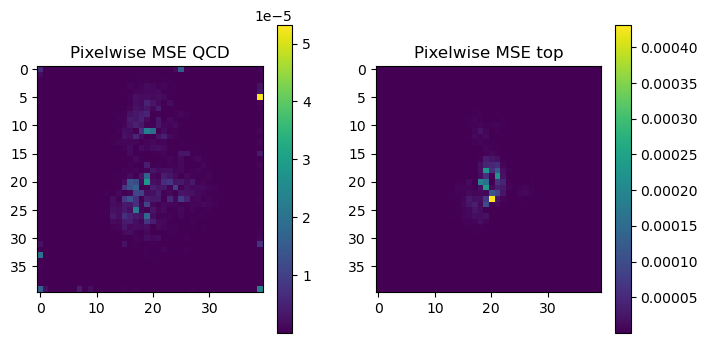

In [348]:
# TODO: Visualize pixel-wise MSE, plot ROC
# pixel wide MSE, scaled by average pixel value
MSE_qcd = (np.mean(np.array(img_qcd),axis=0) - np.mean(np.array(out_qcd), axis=0))**2 
MSE_qcd = (np.mean(np.array(img_top),axis=0) - np.mean(np.array(out_top), axis=0))**2
# MSE_top = np.mean((np.array(img_top) - np.array(out_top))**2, axis=0) / AVG_top

print('total MSE QCD:', round(MSE_qcd.sum(),5))
print('total MSE top:', round(MSE_top.sum(),5))

fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(MSE_qcd)
plt.colorbar()
plt.title('Pixelwise MSE QCD')
plt.subplot(1,2,2)
plt.imshow(MSE_top)
plt.colorbar()
plt.title('Pixelwise MSE top')

One can see that the cnn autoencoder always yields the very same output image. We suspect that there is a problem with information flow through the bottleneck, so that the network tries to produce the best average output irrespectrive of the input over that it does not have any information. 